# CIS6800: Project 1b: Deep Learning Basics Part B

### Instructions:
* This is an individual assignment. Collaborating with others is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python. You should only use PyTorch to complete this project.


In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
rng_seed = 1144

# Download MNIST
torchvision.datasets.MNIST('.', download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

## 4. Adversarial Images (30%)
In this part you will see how you can use the gradients of the network to generate adversarial
images. Using these images that look almost identical the original you will be able to fool
different neural networks. You will also see that these images also affect different neural
networks and expose a security issue of CNNs that malicious users can take advantage of.
An example is shown in Figure 4. You are encouraged to read the relevant papers [1, 2]
before solving this part.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW1/images/fig4.png"/></div>

<center>Figure 4: An adversarial example demonstrated in [1].</center>

1. (10%) Use the trained network from question 3 to generate adversarial images with
constraints. The constraints that you have are:

  1. You are not allowed to erase parts of the image, i.e. $I_\text{pert} \ge I$ at each pixel location.
  2. The perturbed image has to take valid values, i.e. $-1 \le I_\text{pert} \le 1$.

  The algorithm works as follows:
  
  1. Let $I$ be a test image of your dataset that you want to perturb that is classified correctly by the network. Let $I_\epsilon$ be the perturbation that you should initialize
with zeros.
  2. Feed $I_\text{pert} = I + I_\epsilon$ in the network.
  3. Calculate the loss given the ground truth label ($y_\mathrm{gt}$). Let the loss be $L(x,y |\theta)$ where $\theta$ are the learned weights.
  4. Compute the gradients with respect to $I_\text{pert}$, i.e., $\nabla_{I_\text{pert}} L(I_\text{pert}, y_\mathrm{gt} | \theta)$. Using backpropagation, compute $\nabla_{I_\epsilon} L(I_\epsilon,y_\mathrm{gt} | \theta)$, i.e. the gradients with respect to the perturbation.
  5. Use the Fast Gradient Sign method to update the perturbation, i.e., $I_\epsilon = I_\epsilon + \epsilon\,\text{sign}(\nabla_{I_\epsilon} L(I_\epsilon, y_\mathrm{gt}))$, where $\epsilon$ is a small constant of your choice.
  6. Repeat A-D until the network classify the input image $I_\text{pert}$ as an arbitrary
wrong category with confidence (probability) at least $90\%$.

  Generate 2 examples of adversarial images. Describe the difference between the adversarial images and the original images.

In [6]:
# Setups and Initializations for training
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# Create your network here (do not change this name)
class DigitClassification(torch.nn.Module):
  def __init__(self):
      super(DigitClassification,self).__init__()
      # Conv. and Pool. Layer 1
      # Conv1 Input: 28*28*1, Kernel: 5*5*32 
        # Padding 'same': means the output has the same size with input. Padding size: 5//2=2 (or floor(5/2))
        # Output: 28*28*32, i.e. floor((W-K+2P)/S)+1 and floor((H-K+2P)/S)+1
      # Pool1 Input: 28*28*32, Kernel: 2*2, Stride: 2, Output: 14*14*32
      self.layer1 = nn.Sequential()
      self.layer1.add_module("Conv1", nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding='same'))
      self.layer1.add_module("BN1", nn.BatchNorm2d(num_features=32))
      self.layer1.add_module("ReLu1", nn.ReLU())
      self.layer1.add_module("Pool1",nn.AvgPool2d(kernel_size=2, stride=2, padding=0))

      # Conv. and Pool Layer 2
      # Conv2 Input: 14*14*32, Kernel: 5*5*32, Padding "same", Ouput: 14*14*32
      # Pool2 Input: 14*14*32, Kernel: 2*2, Stride: 2, Output: 7*7*32
      self.layer2 = nn.Sequential()
      self.layer2.add_module("Conv2", nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding='same'))
      self.layer2.add_module("BN2", nn.BatchNorm2d(num_features=32))
      self.layer2.add_module("ReLu2", nn.ReLU())
      self.layer2.add_module("Pool2",nn.AvgPool2d(kernel_size=2, stride=2, padding=0))

      # Conv. and Pool Layer 3
      # Conv3 Input: 7*7*32, Kernel: 5*5*64, Padding "same", Ouput: 7*7*64
      # Pool3 Input: 7*7*64, Kernel: 2*2, Stride: 2, Output: 3*3*64
      self.layer3 = nn.Sequential()
      self.layer3.add_module("Conv3", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same'))
      self.layer3.add_module("BN3", nn.BatchNorm2d(num_features=64))
      self.layer3.add_module("ReLu3", nn.ReLU())
      self.layer3.add_module("Pool3",nn.AvgPool2d(kernel_size=2, stride=2, padding=0))

      # Fully Connected 1
      # Input: 3*3*64, Ouput: 64
      self.fullycon1 = nn.Sequential()
      self.fullycon1.add_module("FC1", nn.Linear(in_features=3 * 3 * 64, out_features=64))
      self.fullycon1.add_module("FC1BN", nn.BatchNorm1d(num_features=64))
      self.fullycon1.add_module("FC1ReLu", nn.ReLU())

      # Fully Connected 2
      # Input: 64, Ouput: 10
      self.fullycon2 = nn.Sequential()
      self.fullycon2.add_module("FC2", nn.Linear(in_features=64, out_features=10))

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = x.view (-1, 3 * 3 * 64)
    x = self.fullycon1(x)
    x = self.fullycon2(x)
    return x


true label: 3 


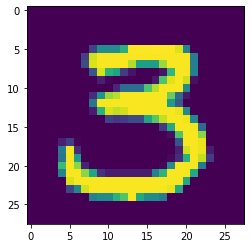


 Attack Iteration: 0, loss: 0.000, current_predict_label: 3


 Attack Iteration: 10, loss: 2.178, current_predict_label: 8


 Attack Iteration: 10, misclassified label: 8, Confidence: 0.9561433792114258 


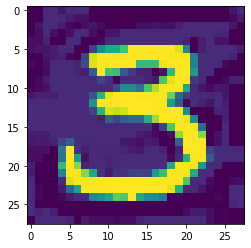

true label: 8 


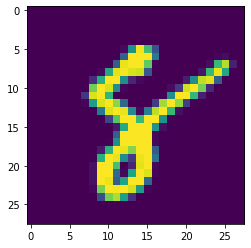


 Attack Iteration: 0, loss: 0.000, current_predict_label: 8


 Attack Iteration: 10, loss: 0.052, current_predict_label: 8


 Attack Iteration: 15, misclassified label: 4, Confidence: 0.9158722758293152 


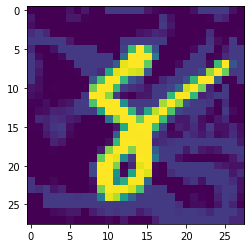

In [7]:
# don't change the signature of this function (image, image_pert -> [N, 1, H, W])
def arbitrary_adversary(model, image, original_label):
  # Setups and Initializations for training
  # CUDA for PyTorch
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  perturbation = torch.zeros(image.size()).to(device)
  perturbation.requires_grad = True
  max_step = 1000
  eps = 0.02
  for i in range(max_step):
    # Start FGSM Attack, Follow the steps stated above
    # perturbation : I_eps in HW document, image_per: I_pert in HW document
    model.zero_grad()
    # Contraints: take the valid values
    output = model((image + perturbation).clamp(min=-1, max=1))
    loss = F.cross_entropy(output, original_label)
    loss.backward()
    perturbation_grad = perturbation.grad.data
    sign_perturbation_grad = perturbation_grad.sign()
    # Contraints: perturbation should be positive (do not erase parts of the image)
    # perturbation is a leaf tensor, so use .data to take the inplace operation
    perturbation.data += eps * sign_perturbation_grad   
    perturbation.data = perturbation.clamp(min=0)
    # Contraints: take the valid values
    image_pert = image + perturbation.data
    image_pert = torch.clamp(image_pert, -1, 1)

    # Predict and calculate the loss
    output_pert = model(image_pert)
    predicted = torch.max(output_pert.data, 1)[1]
    confidence = torch.max(F.softmax(output_pert.data,dim=1))
    if i % 10 == 1:
      print('\n Attack Iteration: {}, loss: {:.3f}, current_predict_label: {}\n'.format(i-1,loss.detach().cpu().item(), 
      predicted.detach().cpu().item()))

    if predicted.item() != original_label.item() and confidence >= 0.90:
      print("\n Attack Iteration: {}, misclassified label: {}, Confidence: {} ".format(i-1, predicted.detach().cpu().item(),confidence))
      image_pert = image_pert.detach().cpu()
      break
  return image_pert

# load two pictures and generate the adversarial images
# Setps for image loaders. Normalize the input to (-1,1)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5), (0.5))])

image_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform),
    batch_size=1, shuffle=True)

# Setups and Initializations for training
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# load the model
model_path = 'model.pth'
# Instantiate the network
model = DigitClassification().to(device)
# load the parameters saved
model.eval().load_state_dict(torch.load(model_path, map_location='cpu'))
cnt=0

for i in range(100):
  image_iterator=iter(image_loader)
  image, label = image_iterator.next()
  image, label = image.to(device), label.to(device)
  output = model(image)
  predicted = torch.max(output.data, 1)[1]
  # If the initial prediction is wrong, dont bother attacking, just move on
  if predicted.item() != label.item():
    continue
  # Display predicted images 
  print("true label: {} ".format(predicted.detach().cpu().item()))
  plt.imshow(np.squeeze(image.detach().cpu()))
  plt.show()
  # generate adversarial images
  image_pert = arbitrary_adversary(model=model, image=image, original_label=label)
  # Display images
  image_pert = np.squeeze(image_pert)
  plt.imshow(image_pert)
  plt.show()
  cnt += 1
  if cnt == 2:
    break


The first image is labeled 0 and the network originally labeled it correctly. After we purturbated the image, the network now labeled it as 6. Similarly, the second is 6 originally, and labeled 8 after perturbation. However, if we observe the images before and after the perturbation, we can see that the "main" part of the image (the digit part) does not change much intuitively. While through the fast gradient method, we do find changes in the background. Though for human beings, we still focus on the digit itself, and do not get distracted, the perturbated images already fool the network.

2. (10%) For a test image from the dataset, choose a target label yt that you want the network to classify your image as and compute a perturbed image. Note that this is different from what you are asked in part 1, because you want your network to believe that the image has a particular label, not just misclassify the image. You need to modify appropriately the loss function and then perform gradient descent as before. You should still use the constraints from part 1.

true label: 8 


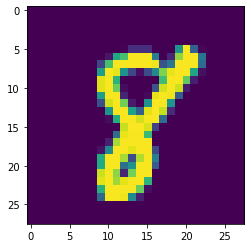


 Attack Iteration: 0, loss: -19.653, current_predict_label: 8


 Attack Iteration: 104, predict label: 1,target label:1, Confidence: 0.9015573263168335



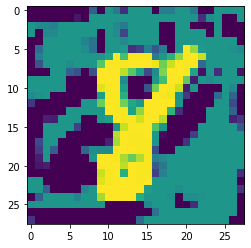

true label: 6 


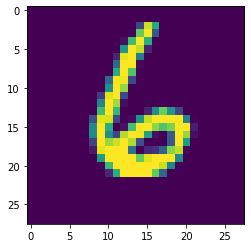


 Attack Iteration: 0, loss: -20.415, current_predict_label: 6


 Attack Iteration: 83, predict label: 1,target label:1, Confidence: 0.9039269089698792



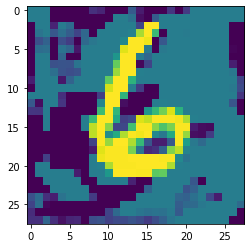

In [8]:
# don't change the signature of this function (image, image_pert -> [N, 1, H, W])
def targeted_adversary(model, image, target_label):
  # Setups and Initializations for training
  # CUDA for PyTorch
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  perturbation = torch.zeros(image.size()).to(device)
  perturbation.requires_grad = True
  max_step = 100000
  eps = 0.01
  for i in range(max_step):
    # Start FGSM Attack, Follow the steps stated above
    # perturbation : I_eps in HW document, image_per: I_pert in HW document
    model.zero_grad()
    # Contraints: take the valid values
    output = model((image + perturbation).clamp(min=-1, max=1))
    # We want the network to believe that the image has that label, so the loss
    # should be -L_CE so that they would be similar (or change the gradient ascent
    # to gradient descent: perturbation.data -= eps * sign_perturbation_grad, they are equivalent)
    loss = -F.cross_entropy(output, target_label)
    loss.backward()
    perturbation_grad = perturbation.grad.data
    sign_perturbation_grad = perturbation_grad.sign()
    # Contraints: perturbation should be positive (do not erase parts of the image)
    # perturbation is a leaf tensor, so use .data to take the inplace operation
    perturbation.data += eps * sign_perturbation_grad   
    perturbation.data = perturbation.clamp(min=0)
    # Contraints: take the valid values
    image_pert = image + perturbation.data
    image_pert = torch.clamp(image_pert, -1, 1)

    # Predict and calculate the loss
    output_pert = model(image_pert)
    predicted = torch.max(output_pert.data, 1)[1]
    confidence = torch.max(F.softmax(output_pert.data,dim=1))
    if i % 1000 == 1:
      print('\n Attack Iteration: {}, loss: {:.3f}, current_predict_label: {}\n'.format(i-1,loss.detach().cpu().item(), 
      predicted.detach().cpu().item()))

    if predicted.item() == target_label.item() and confidence>= 0.9:
      print('\n Attack Iteration: {}, predict label: {},target label:{}, Confidence: {}\n'.format(i-1,predicted.detach().cpu().item(), target_label.detach().cpu().item(),confidence))
      image_pert = image_pert.detach().cpu()
      break
  return image_pert

# Display images
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# load the model
model_path = 'model.pth'
# Instantiate the network
model = DigitClassification().to(device)
# load the parameters saved
model.eval().load_state_dict(torch.load(model_path, map_location='cpu'))
# choose the label to be 1
target_label=torch.tensor([1])
cnt=0

for i in range(100):
  image_iterator=iter(image_loader)
  image, label = image_iterator.next()
  image, label = image.to(device), label.to(device)
  output = model(image)
  predicted = torch.max(output.data, 1)[1]
  # If the initial prediction is wrong or just the targeted label , dont bother attacking, just move on
  if predicted.item() != label.item() or predicted.item() == target_label.item():
    continue
  # Display predicted images 
  print("true label: {} ".format(predicted.detach().cpu().item()))
  plt.imshow(np.squeeze(image.detach().cpu()))
  plt.show()
  # generate adversarial images
  image_pert = targeted_adversary(model=model, image=image, target_label=target_label)
  # Display images
  image_pert = np.squeeze(image_pert)
  plt.imshow(image_pert)
  plt.show()
  cnt += 1
  if cnt == 2:
    break


<!-- BEGIN QUESTION -->

3. (10%) Retrain the network from the previous problem. Use some of the adversarial images you generated in parts (1) and (2) and feed them in the retrained network. What do you observe?

_Type your answer here, replacing this text._

In [ ]:
# adversarial operations and generating new data
def arbitrary_adversary(model, image, original_label):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  perturbation = torch.zeros(image.size()).to(device)
  perturbation.requires_grad = True
  max_step = 1000
  eps = 0.02
  for i in range(max_step):
    model.zero_grad()
    output = model((image + perturbation).clamp(min=-1, max=1))
    loss = F.cross_entropy(output, original_label)
    loss.backward()
    perturbation_grad = perturbation.grad.data
    sign_perturbation_grad = perturbation_grad.sign()
    perturbation.data += eps * sign_perturbation_grad   
    perturbation.data = perturbation.clamp(min=0)
    image_pert = image + perturbation.data
    image_pert = torch.clamp(image_pert, -1, 1)
    output_pert = model(image_pert)
    predicted = torch.max(output_pert.data, 1)[1]
    confidence = torch.max(F.softmax(output_pert.data,dim=1))
    if predicted.item() != original_label.item() and confidence >= 0.90:
      image_pert = image_pert.detach().cpu()
      break
  return image_pert

def targeted_adversary(model, image, target_label):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  perturbation = torch.zeros(image.size()).to(device)
  perturbation.requires_grad = True
  max_step = 100000
  eps = 0.01
  for i in range(max_step):
    model.zero_grad()
    output = model((image + perturbation).clamp(min=-1, max=1))
    loss = -F.cross_entropy(output, target_label)
    loss.backward()
    perturbation_grad = perturbation.grad.data
    sign_perturbation_grad = perturbation_grad.sign()
    perturbation.data += eps * sign_perturbation_grad   
    perturbation.data = perturbation.clamp(min=0)
    image_pert = image + perturbation.data
    image_pert = torch.clamp(image_pert, -1, 1)
    output_pert = model(image_pert)
    predicted = torch.max(output_pert.data, 1)[1]
    confidence = torch.max(F.softmax(output_pert.data,dim=1))
    if predicted.item() == target_label.item() and confidence>= 0.9:
      image_pert = image_pert.detach().cpu()
      break
  return image_pert

def batch_image_pert(model, image_batch, label_batch, type='arbitrary', target_label=None):
  # This function is used to generate batch of perturbated image to train the netwok
  # type can be either arbitrary or targeted, if targeted is assigned, target_label should also be assigned
  image_pert_batch = torch.zeros_like(image_batch[0][None])
  label_pert_batch = torch.zeros_like(label_batch[0][None])
  for image, label in zip(image_batch, label_batch):
    image = image[None]
    label = label[None]
    # print(label)
    if type == 'arbitrary':
      image_pert = arbitrary_adversary(model=model, image=image, original_label=label)
    else:
      image_pert = targeted_adversary(model, image, target_label=target_label)
    label_pert = torch.argmax(model(image_pert), dim=1)
    image_pert_batch = torch.cat((image_pert_batch,image_pert), dim=0)
    label_pert_batch = torch.cat((label_pert_batch,label_pert), dim=0)
  return image_pert_batch[1:, :, :, :], label_pert_batch[1:]

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5), (0.5))])

image_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform),
    batch_size=2000, shuffle=True)

# generate 2000 adversirial images for retraining, 1500 would be mixed in orginial minist trainning set, the other 500 would be used for testing
# comment for sake of not running timeout on aotuograder, uncomment to see full code
'''
image_batch, label_batch = next(iter(image_loader))
image_pert_batch, label_pert_batch = batch_image_pert(model, image_batch, label_batch)
print(label_batch)
print(label_pert_batch)
# make sure the image is really attacked
print(label_batch.eq(label_pert_batch).sum().item()
'''

tensor([4, 8, 9,  ..., 7, 1, 1])
tensor([9, 9, 4,  ..., 2, 4, 7])
0


In [ ]:
# define training and testing process for adverserial datasets
def train_adv(Net, device, train_loader, optimizer, criterion, epoch, display_interval, train_pert, train_label):
  Net.train()
  running_loss = 0
  running_correct = 0
  cnt=0
  for batch_index, (inputs, labels) in enumerate(train_loader,0):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()   # remember to clear the gradients
    outputs = Net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    running_loss += loss.item() * inputs.size(0)
    optimizer.step()
    pred_outputs = torch.max(outputs.data, dim=1)[1] # get the prediction
    running_correct += (pred_outputs == labels).sum()
    
    inputs_adv, labels_adv = train_pert[(batch_index)*3:(batch_index+1)*3,:,:,:].to(device), train_label[(batch_index)*3:(batch_index+1)*3].to(device)
    outputs = Net(inputs_adv)
    loss = criterion(outputs, labels_adv)
    loss.backward()
    running_loss += loss.item() * inputs_adv.size(0)
    optimizer.step()
    pred_outputs = torch.max(outputs.data, dim=1)[1]
    running_correct += (pred_outputs == labels_adv).sum()

    # Print the training process
    if batch_index % display_interval == 0:
      print('Train Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
          epoch+1, batch_index*(len(inputs)+3), len(train_loader.dataset)+1500, 100.*batch_index / len(train_loader),
          loss.item(), float(running_correct*100) / float((train_batch_size+3)*(batch_index + 1))))
  epoch_loss = running_loss / (len(train_loader.dataset)+1500)
  epoch_accu = (running_correct) / (len(train_loader.dataset)+1500)
  train_loss.append(epoch_loss)
  train_accu.append(epoch_accu)
  print('\nTrain set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch_loss, running_correct, len(train_loader.dataset)+len(train_label),
        100. * epoch_accu))

def test_adv(Net, device, test_loader, criterion, epoch, test_pert, test_label):
  Net.eval()
  running_loss = 0
  running_correct = 0
  with torch.no_grad(): # normal MINST set
    for batch_index, (inputs, labels) in enumerate(test_loader,0):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = Net(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * inputs.size(0)
      pred_outputs = torch.max(outputs.data, dim=1)[1]
      running_correct += (pred_outputs == labels).sum()

      inputs_adv, labels_adv = test_pert[(batch_index)*5:(batch_index+1)*5,:,:,:].to(device), test_label[(batch_index)*5:(batch_index+1)*5].to(device)
      outputs = Net(inputs_adv)
      loss = criterion(outputs, labels_adv)
      running_loss += loss.item() * inputs_adv.size(0)
      pred_outputs = torch.max(outputs.data, dim=1)[1]
      running_correct += (pred_outputs == labels_adv).sum()
      
  epoch_loss =  running_loss / (len(test_loader.dataset)+500)
  epoch_accu = (running_correct) / (len(test_loader.dataset)+500)
  test_loss.append(epoch_loss)
  test_accu.append(epoch_accu)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch_loss, running_correct, len(test_loader.dataset)+len(test_label),
        100. * epoch_accu))

In [ ]:
# split the generated datasets into train and test sets
train_pert, train_label = image_pert_batch[0:1500,:,:,:], label_batch[0:1500]
test_pert, test_label = image_pert_batch[1500:2000,:,:,:], label_batch[1500:2000]

In [ ]:
# Retrain the network (same structure that of Project 1.a)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# load the old weight for comparison
model_path = 'model.pth'
Net_original = DigitClassification().to(device)
Net_original.eval().load_state_dict(torch.load(model_path, map_location='cpu'))
# New weights that would be trained and compared
Net_adv = DigitClassification().to(device)
LR = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net_original.parameters(),lr=LR)
optimizer_adv = torch.optim.Adam(Net_adv.parameters(),lr=LR)
display_interval = 100
train_loss = []
train_accu = []
test_loss = []
test_accu = []
train_batch_size=120
test_batch_size=100

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform),
    batch_size=train_batch_size, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform),
    batch_size=test_batch_size, shuffle=True, num_workers=8)
# Net, device, train_loader has been setup before
# comment for sake of not running timeout on aotuograder, uncomment to see full code
'''
num_epochs = 15
for epoch in range(num_epochs):
  train_adv(Net=Net_adv, device=device, train_loader=train_loader, optimizer=optimizer_adv, criterion=criterion, epoch=epoch, display_interval=display_interval,train_pert=train_pert,train_label=train_label)
  test_adv(Net=Net_adv, device=device, test_loader=test_loader, criterion=criterion, epoch=epoch, test_pert=test_pert, test_label=test_label)
test_adv(Net=Net_original, device=device, test_loader=test_loader, criterion=criterion, epoch=1, test_pert=test_pert, test_label=test_label)
'''

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch : 1 [0/61500 (0%)]	Loss: 2.111973	 Accuracy:18.699%
Train Epoch : 1 [12300/61500 (20%)]	Loss: 0.117307	 Accuracy:81.035%
Train Epoch : 1 [24600/61500 (40%)]	Loss: 1.527567	 Accuracy:86.276%
Train Epoch : 1 [36900/61500 (60%)]	Loss: 0.134211	 Accuracy:87.772%
Train Epoch : 1 [49200/61500 (80%)]	Loss: 0.015776	 Accuracy:88.407%

Train set: Avg. loss: 0.3468, Accuracy: 54921/61500 (89%)


Test set: Avg. loss: 0.2225, Accuracy: 9738/10500 (93%)

Train Epoch : 2 [0/61500 (0%)]	Loss: 0.037879	 Accuracy:95.935%
Train Epoch : 2 [12300/61500 (20%)]	Loss: 0.159039	 Accuracy:92.288%
Train Epoch : 2 [24600/61500 (40%)]	Loss: 0.538116	 Accuracy:92.885%
Train Epoch : 2 [36900/61500 (60%)]	Loss: 0.145938	 Accuracy:93.374%
Train Epoch : 2 [49200/61500 (80%)]	Loss: 0.047084	 Accuracy:93.709%

Train set: Avg. loss: 0.1919, Accuracy: 57840/61500 (94%)


Test set: Avg. loss: 0.1706, Accuracy: 9912/10500 (94%)

Train Epoch : 3 [0/61500 (0%)]	Loss: 0.016802	 Accuracy:96.748%
Train Epoch : 3 [123

The retrain and comparison setups are described below:
1. **Dataset**: MNIST dataset is a large dataset. Therefore, 2000 adversarial images are randomly picked and generated from the MNIST dataset using the `arbitrary_adversary` function defined previously to provide sufficient attacks. The generated images are split into 1500 training images and 500 testing images. 
2. **Retraining setup:** For the retrained network, it has the same structure as that of Project 1.a, but the weights are trained from the new 61500 (60000 original+1500 adversarial) images. For sake of a fair comparison, the hyperparameters (except for the epochs) are set to be the same as Project 1.a
2. **Test and Comparison:** To show the effect of thr adversary and how networks adapt to the attack. The original network (which is trained on 60000 MINIST training dataset and gets over 99% accuracy on 10000 MINIST testing dataset in Project 1.a) is loaded. The retrained and original networks would run the same 10500(10000 original+500 adversarial) test images and their performances would be compared.


Observations:
The processes and outcomes are shown in the above blocks
1. First of all, with the same hyperparameter and network structure, the retrained network is much harder to train than the original network.  In project 1.a, it takes 10 epochs for the network to achieve 99% accuracy both on the training and testing set. In the retrained process, it would take 15 epochs for the network to first reach 98% accuracy on the training set and 99% accuracy on the testing set. This probably implies the effective attack caused by adversarial images.
2. When the original network test the new testing set, it only gets 95% accuracy. Considering that the adversarial images take about 5% portion of the testing set, this probably means that the original network misclassifies most of the adversarial images. While the retrained network can achieve 99% accuracy. This phenomenon is understadable, since the gradient used to generate the adversarial images is derived from the original model, the attack itself is targeted at the model. So, when the weights or network structure changed, the influence faded.






<!-- END QUESTION -->

## References
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW1/images/refs.png"/, width=600
         ></div>

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (b), your submission should consist of two files: this notebook and the saved weights from question 3. There is no need to upload the new, retrained, weights.

**Please save before exporting!**